In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set up 

In [2]:
!sudo apt-get update

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [76.0 kB]
Get:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 http://security.ubuntu.com/ubu

In [3]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_312"
OpenJDK Runtime Environment (build 1.8.0_312-8u312-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.312-b07, mixed mode)


In [4]:
!pip install bigdl==0.13.0

     |████████████████████████████████| 114.0 MB 57 kB/s 
     |████████████████████████████████| 218.4 MB 51 kB/s 
     |████████████████████████████████| 197 kB 53.5 MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.6-py2.py3-none-any.whl size=218814407 sha256=ba3d2275087585d4df70ad9f2c7fb5a59983e8c2ff9c7da1d74c6b85990f3726
  Stored in directory: /root/.cache/pip/wheels/f1/42/b0/ba397759613f4feb1611021a2503e60e344e546671b2ae04f8
Successfully built pyspark


In [5]:
#!pip install pillow==4.0.0

# Prepare data RDD for BigDL

In [6]:
import matplotlib
matplotlib.use('Agg')
%pylab inline

import pandas
import datetime as dt

from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from bigdl.dataset.transformer import *
from pyspark import SparkContext
from matplotlib.pyplot import imshow
from bigdl.util import common
import matplotlib.pyplot as plt
sc=SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[*]").set("spark.driver.memory","8g"))

init_engine()

Populating the interactive namespace from numpy and matplotlib
Prepending /usr/local/lib/python3.7/dist-packages/bigdl/share/conf/spark-bigdl.conf to sys.path


In [7]:
# # Count again
nameclass = ['Banhhoi', 'Banhuot', 'Bokho', 'Phalau']
cnt=0
for name in nameclass:
  import os, os.path
  target_dir = '/content/drive/MyDrive/Study/ComputingParallel/VinaFood21_7Class/'+ name
  count = len([name for name in os.listdir(target_dir)])
  cnt = cnt + count
  print(count)

print('Total: ',cnt)

1241
1159
701
726
Total:  3827


## Read and resize images

### Save images and labels data

In [8]:
# # Save
# with open('/content/drive/MyDrive/Study/ComputingParallel/VinaFood21_7Class/Food4_imagesData.npy', 'wb') as f:
#     np.save(f, image_data)

# with open('/content/drive/MyDrive/Study/ComputingParallel/VinaFood21_7Class/Food4_lablesData.npy', 'wb') as f:
#     np.save(f, Y_data)

### Quickly load images and labels data as Numpy

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import zipfile  # unziping 
import glob  # finding image paths
from skimage.io import imread  # reading images
from skimage.transform import resize  # resizing images
import os

IMG_SIZE = 28 #(image resolution of 256 x 256 used for example)
num_chanel = 3

nameclass = ['Banhhoi', 'Banhuot', 'Bokho', 'Phalau']

In [10]:
import pandas as pd
import numpy as np
#Load
with open('/content/drive/MyDrive/Study/ComputingParallel/VinaFood21_7Class/Food4_imagesData.npy', 'rb') as f:
    image_data = np.load(f)

with open('/content/drive/MyDrive/Study/ComputingParallel/VinaFood21_7Class/Food4_lablesData.npy', 'rb') as f:
    Y_data = np.load(f)

In [11]:
X_train, X_val_test, Y_train, Y_val_test = train_test_split(image_data, Y_data, test_size = 0.3, random_state= 42)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size = 0.5, random_state = 42)

In [12]:
# Open header

training_mean = np.mean(X_train)
training_std = np.std(X_train)
rdd_train_images = sc.parallelize(X_train)
rdd_train_labels = sc.parallelize(Y_train)
rdd_val_images = sc.parallelize(X_val)
rdd_val_labels = sc.parallelize(Y_val)
rdd_test_images = sc.parallelize(X_test)
rdd_test_labels = sc.parallelize(Y_test)

train_data = rdd_train_images.zip(rdd_train_labels).map(lambda x:
                                    common.Sample.from_ndarray(
                                    (x[0] - training_mean) / training_std,
                                    x[1] + 1))

val_data = rdd_val_images.zip(rdd_val_labels).map(lambda x:
                                    common.Sample.from_ndarray(
                                    (x[0] - training_mean) / training_std,
                                    x[1] + 1))

test_data = rdd_test_images.zip(rdd_test_labels).map(lambda x:
                                    common.Sample.from_ndarray(
                                    (x[0] - training_mean) / training_std,
                                    x[1] + 1))

In [13]:
train_data = train_data.map(lambda s: Sample.from_ndarray(np.resize(s.features[0].to_ndarray(), (IMG_SIZE, IMG_SIZE, 3)), s.label.to_ndarray()))
val_data = val_data.map(lambda s: Sample.from_ndarray(np.resize(s.features[0].to_ndarray(), (IMG_SIZE, IMG_SIZE, 3)), s.label.to_ndarray()))
test_data = test_data.map(lambda s: Sample.from_ndarray(np.resize(s.features[0].to_ndarray(), (IMG_SIZE, IMG_SIZE, 3)), s.label.to_ndarray()))
#print(train_data.count())
#print(test_data.count())
#print(val_data.count())

# Main

In [14]:
learning_rate = 0.05
num_epochs = 100
#batch_size = 4

num_classes = 4
batchSize=128
#IMG_SIZE = (224, 224)

In [15]:
# Create a LeNet model
def AlexNet(class_num):
    model = Sequential()
    model.add(Reshape([3, IMG_SIZE, IMG_SIZE]))
    model.add(SpatialConvolution(n_input_plane=3, n_output_plane=64, kernel_w=3, kernel_h=3, stride_w=4, stride_h=4, pad_w=4, pad_h=4).set_name('conv1'))
    model.add(ReLU())
    model.add(SpatialMaxPooling(kw=3, kh=3, dw=2, dh=2).set_name('pool1'))
    model.add(ReLU())
    model.add(SpatialConvolution(n_input_plane=64, n_output_plane=192, kernel_w=3, kernel_h=3, pad_h=2, pad_w=2).set_name('conv2'))
    model.add(ReLU())
    model.add(SpatialMaxPooling(kw=3, kh=3, dw=2, dh=2).set_name('pool2'))
    model.add(SpatialConvolution(n_input_plane=192, n_output_plane=384, kernel_w=3, kernel_h=3, pad_h=2, pad_w=2).set_name('conv3'))
    model.add(ReLU())
    model.add(SpatialConvolution(n_input_plane=384, n_output_plane=256, kernel_w=3, kernel_h=3, pad_h=2, pad_w=2).set_name('conv4'))
    model.add(ReLU())
    model.add(SpatialConvolution(n_input_plane=256, n_output_plane=256, kernel_w=3, kernel_h=3, pad_h=2, pad_w=2).set_name('conv5'))
    model.add(ReLU())
    model.add(SpatialMaxPooling(kw=3, kh=3, dw=2, dh=2).set_name('pool2'))
    
    model.add(Reshape([256*3*3]))
    model.add(Dropout(init_p=0.5))
    model.add(Linear(256*3*3, 4096).set_name('fc1'))
    model.add(ReLU())
    model.add(Dropout(init_p=0.5))
    model.add(Linear(4096, 4096).set_name('fc2'))
    model.add(ReLU())
    model.add(Linear(4096, class_num).set_name('fc2'))
    
    model.add(LogSoftMax())
    return model
vgg16_model = AlexNet(num_classes)

creating: createSequential
creating: createReshape
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createReLU
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createReshape
creating: createDropout
creating: createLinear
creating: createReLU
creating: createDropout
creating: createLinear
creating: createReLU
creating: createLinear
creating: createLogSoftMax


In [16]:
# Create an Optimizer
optimizer = Optimizer(
  model=vgg16_model,
  training_rdd=train_data,
  criterion=ClassNLLCriterion(),
  optim_method=SGD(learningrate=learning_rate, learningrate_decay=0.0002),
  end_trigger=MaxEpoch(num_epochs),
  batch_size=batchSize)

# Set the validation logic
optimizer.set_validation(
    batch_size=batchSize,
    val_rdd=test_data,
    trigger=EveryEpoch(),
    val_method=[Top1Accuracy()]
)

app_name='vgg16-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
                                     app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(5))
val_summary = ValidationSummary(log_dir='/tmp/bigdl_summaries',
                                        app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print("saving logs to ",app_name)

creating: createClassNLLCriterion
creating: createDefault
creating: createSGD
creating: createMaxEpoch
creating: createDistriOptimizer


/usr/local/lib/python3.7/dist-packages/bigdl/optim/optimizer.py:864: UserWarning: You are recommended to use `create` method to create an optimizer.
  warnings.warn("You are recommended to use `create` method to create an optimizer.")


creating: createEveryEpoch
creating: createTop1Accuracy
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
saving logs to  vgg16-20220129-064815


In [17]:
#%%time
# Boot training process
trained_model = optimizer.optimize()
print("Optimization Done.")

Optimization Done.


In [18]:
# trained_model.save('/content/drive/MyDrive/Study/ComputingParallel/VinaFood21_7Class/AlexnetModel')

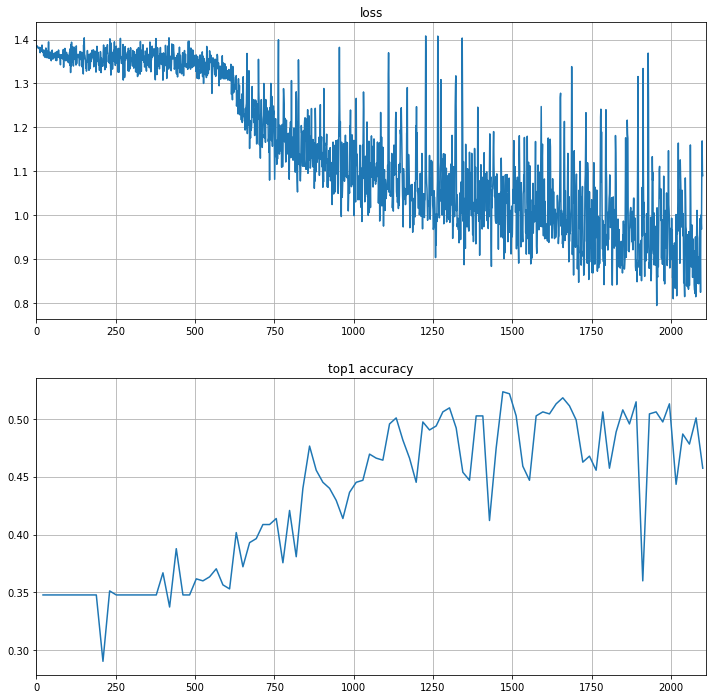

In [19]:
loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0]+10)
plt.title("top1 accuracy")
plt.grid(True)

## Evaluate Performance

In [20]:
def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return int(l[0] - 1)

##Train Set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ground Truth labels:
1, 3, 0, 0, 0, 3, 2, 2
Predicted labels:
0, 3, 0, 2, 1, 2, 3, 2


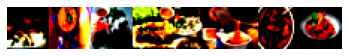

In [21]:
#%%time
predictions = trained_model.predict(train_data)
imshow(np.column_stack([np.array(s.features[0].to_ndarray()).reshape(28,28,3) for s in train_data.take(8)]),cmap='gray'); plt.axis('off')
print('Ground Truth labels:')
print(', '.join(str(map_groundtruth_label(s.label.to_ndarray())) for s in train_data.take(8)))
print('Predicted labels:')
print(', '.join(str(map_predict_label(s)) for s in predictions.take(8)))

In [22]:
y_pred  = [map_groundtruth_label(s.label.to_ndarray()) for s in train_data.collect()]
y_true  = [map_predict_label(s) for s in predictions.collect()]

The prediction accuracy is 51.72%


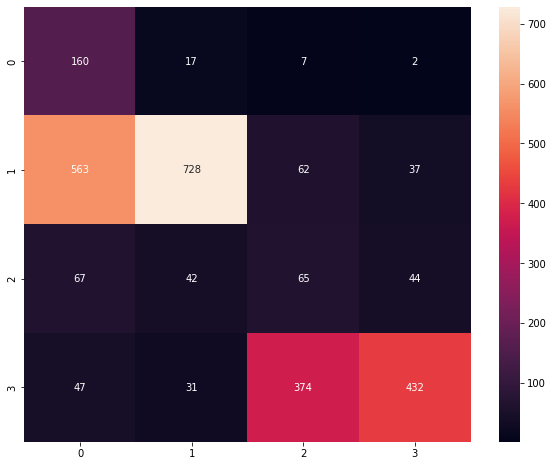

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn
acc = accuracy_score(y_true, y_pred)
print("The prediction accuracy is %.2f%%"%(acc*100))

cm = confusion_matrix(y_true, y_pred)
cm.shape
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,fmt='d');

In [24]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
#y_pred = alex.predict(np.array(X_train, np.float32))
#y_pred = np.argmax(y_pred, axis = -1)
print("accuracy: " + str(accuracy_score(y_true, y_pred)))
#print("f1-score: " + str(f1_score(y_true, y_pred, average='macro')))
target_names = nameclass
print('Classification report in Training set')
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

accuracy: 0.5171769977595221
Classification report in Training set
              precision    recall  f1-score   support

     Banhhoi     0.1912    0.8602    0.3128       186
     Banhuot     0.8900    0.5237    0.6594      1390
       Bokho     0.1280    0.2982    0.1791       218
      Phalau     0.8388    0.4887    0.6176       884

    accuracy                         0.5172      2678
   macro avg     0.5120    0.5427    0.4422      2678
weighted avg     0.7625    0.5172    0.5824      2678



## Test Set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ground Truth labels:
0, 1, 3, 2, 0, 3, 1, 0
Predicted labels:
2, 1, 3, 3, 0, 3, 3, 0


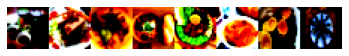

In [25]:
#%%time
predictions = trained_model.predict(test_data)
imshow(np.column_stack([np.array(s.features[0].to_ndarray()).reshape(28,28,3) for s in test_data.take(8)]),cmap='gray'); plt.axis('off')
print('Ground Truth labels:')
print(', '.join(str(map_groundtruth_label(s.label.to_ndarray())) for s in test_data.take(8)))
print('Predicted labels:')
print(', '.join(str(map_predict_label(s)) for s in predictions.take(8)))

In [26]:
y_pred  = [map_groundtruth_label(s.label.to_ndarray()) for s in test_data.collect()]
y_true  = [map_predict_label(s) for s in predictions.collect()]

The prediction accuracy is 45.74%


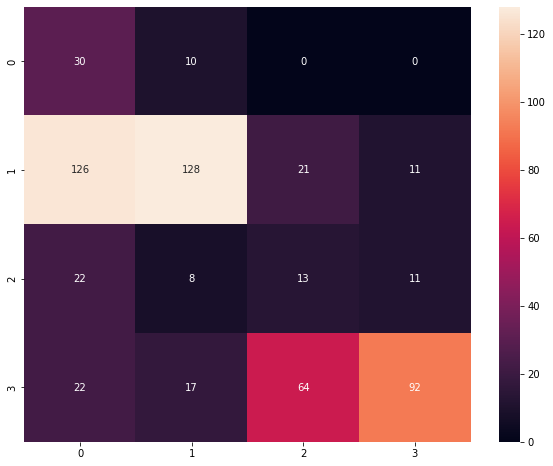

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn
acc = accuracy_score(y_true, y_pred)
print("The prediction accuracy is %.2f%%"%(acc*100))

cm = confusion_matrix(y_true, y_pred)
cm.shape
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,fmt='d');

In [28]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
#y_pred = alex.predict(np.array(X_train, np.float32))
#y_pred = np.argmax(y_pred, axis = -1)
print("accuracy: " + str(accuracy_score(y_true, y_pred)))
#print("f1-score: " + str(f1_score(y_true, y_pred, average='macro')))
target_names = nameclass
print('Classification report in Training set')
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

accuracy: 0.4573913043478261
Classification report in Training set
              precision    recall  f1-score   support

     Banhhoi     0.1500    0.7500    0.2500        40
     Banhuot     0.7853    0.4476    0.5702       286
       Bokho     0.1327    0.2407    0.1711        54
      Phalau     0.8070    0.4718    0.5955       195

    accuracy                         0.4574       575
   macro avg     0.4687    0.4775    0.3967       575
weighted avg     0.6872    0.4574    0.5190       575



In [29]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
#y_pred = alex.predict(np.array(X_train, np.float32))
#y_pred = np.argmax(y_pred, axis = -1)
print("accuracy: " + str(accuracy_score(y_true, y_pred)))
#print("f1-score: " + str(f1_score(y_true, y_pred, average='macro')))
target_names = nameclass
print('Classification report in Training set')
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

accuracy: 0.4573913043478261
Classification report in Training set
              precision    recall  f1-score   support

     Banhhoi     0.1500    0.7500    0.2500        40
     Banhuot     0.7853    0.4476    0.5702       286
       Bokho     0.1327    0.2407    0.1711        54
      Phalau     0.8070    0.4718    0.5955       195

    accuracy                         0.4574       575
   macro avg     0.4687    0.4775    0.3967       575
weighted avg     0.6872    0.4574    0.5190       575



## Validation Set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ground Truth labels:
0, 3, 1, 0, 1, 1, 1, 1
Predicted labels:
0, 3, 1, 1, 1, 0, 1, 1


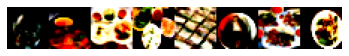

In [30]:
#%%time
predictions = trained_model.predict(val_data)
imshow(np.column_stack([np.array(s.features[0].to_ndarray()).reshape(28,28,3) for s in val_data.take(8)]),cmap='gray'); plt.axis('off')
print('Ground Truth labels:')
print(', '.join(str(map_groundtruth_label(s.label.to_ndarray())) for s in val_data.take(8)))
print('Predicted labels:')
print(', '.join(str(map_predict_label(s)) for s in predictions.take(8)))

In [31]:
y_pred  = [map_groundtruth_label(s.label.to_ndarray()) for s in val_data.collect()]
y_true  = [map_predict_label(s) for s in predictions.collect()]

The prediction accuracy is 44.25%


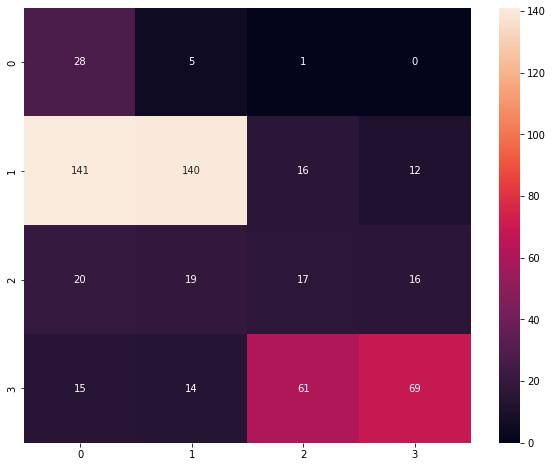

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn
acc = accuracy_score(y_true, y_pred)
print("The prediction accuracy is %.2f%%"%(acc*100))

cm = confusion_matrix(y_true, y_pred)
cm.shape
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,fmt='d');